# Training a Model to Detect Political Sentiment
## Krissy Gianforte
## w266 Section 3, December 2018

The purpose of this project is to explore various models for detecting sentiment or stance in politicians' statements. More specifically, it focuses on the statements Congresspeople have made on their .gov websites regarding Obamacare or healthcare, and attempts to evaluate their sentiment using various recognized training datasets.

For more information on the project goals, design, and outcome, see the accompanying pdf paper.  

## Import necessary packages and modules

In [1]:
# python packages
import pandas as pd # for data handling
from pandas import ExcelFile # for file reading
import numpy as np # for data manipulation and plotting
from progressbar import ProgressBar # for output monitoring
import matplotlib.pyplot as plt # for plotting
%matplotlib inline

# NLTK packages
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# NLTK lexicons and document datasets
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('opinion_lexicon') #lui hu lexicon
from nltk.corpus import opinion_lexicon
from nltk.corpus import sentiwordnet as swn

# NLTK subjectivity analysis
nltk.download('subjectivity')
from nltk.corpus import subjectivity
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Initialize some universal utilities
tokenizer = TreebankWordTokenizer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/krissy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/krissy/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package subjectivity to
[nltk_data]     /home/krissy/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!


/home/krissy/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Import Data and Perform Initial Cleansing

In [2]:
# import data from excel file
df = pd.read_excel('./data/StatementData.xlsx')
print("Column headings:")
print(df.columns)

# add column for "is republican"
df['isRep'] = (df.Party == "R")
# add a column for cross-party voting
df['crossVote'] = (df.isRep != df.Vote) # republicans voting 'no'

# view a bit of the data
df.head()

Column headings:
Index(['ID', 'LastName', 'FirstName', 'State', 'Party', 'Statement', 'Vote'], dtype='object')


,ID,LastName,FirstName,State,Party,Statement,Vote,isRep,crossVote
0,1,Abraham,Ralph,LA,R,"As a rural doctor, I’ve seen the problems our ...",1,True,False
1,2,Adams,Alma,NC,D,Health care is important to our district and t...,0,False,False
2,3,Aderholt,Robert,AB,R,It is important that everyone has access to go...,1,True,False
3,4,Aguilar,Pete,CA,D,NaN,0,False,False
4,5,Allen,Rick,GA,R,NaN,1,True,False


In [3]:
# Initial statistics of interest
# total data rows
print(str(len(df)) + " total rows")

# number of cross-votes (republicans voting no)
print(str(sum(df.crossVote)) + " cross-votes")

430 total rows
21 cross-votes


#### Clean Data Frame

In [4]:
# remove entries that don't have statement data
clean_df = df[df.Statement.notnull()]

# Stats of interest
# total data rows
print(str(len(clean_df)) + " total rows")

# number of cross-votes (republicans voting no)
print(str(sum(clean_df.crossVote)) + " cross-votes")

296 total rows
8 cross-votes


430-295 = 135 Congresspeople did not include statements on their websites (31.4%). 13 of the 21 cross-voting Congresspeople did not include statements, for a disproportionate 61.9%. 

In [5]:
clean_df.head()

,ID,LastName,FirstName,State,Party,Statement,Vote,isRep,crossVote
0,1,Abraham,Ralph,LA,R,"As a rural doctor, I’ve seen the problems our ...",1,True,False
1,2,Adams,Alma,NC,D,Health care is important to our district and t...,0,False,False
2,3,Aderholt,Robert,AB,R,It is important that everyone has access to go...,1,True,False
6,7,Amodei,Mark,NV,R,ObamaCare mandated that all uninsured American...,1,True,False
7,8,Arrington,Jodey,TX,R,It’s time to repeal and replace Obamacare.\n\n...,1,True,False


## Preprocessing Statements

In [6]:
# Filter statements for sentences containing keywords. 
# Clean up line breaks, etc
health_keywords = ["obamacare", "obama care", "affordable care", "aca"]

clean_df['FinalStatement'] = ''

p = False  #for easy debugging; turns printing on and off
pbar = ProgressBar()  # progress bar for cleaning loop

# Extract statements
for ind in pbar(range(len(clean_df))):
    
    # get the statement text
    if p: print("Cleaning statement " + str(ind) + "\n")
    raw_s = clean_df['Statement'].values[ind].lower()  # make it all lowercase
    if p:
        print("\nROW " + str(ind) + " STATEMENT \n")
        print(raw_s)
    
    # split statement by line breaks
    split_s = raw_s.split("\n")
    # throw out empty lines
    if '' in split_s: split_s.remove('')
    
    # split statement by sentences (. character)
    split_s = ''.join(split_s).split(".")
    if p:
        print("\nSENTENCES FROM ROW " + str(ind) + "\n")
        print(split_s)
    
    # filter statement for keywords
    filtered_s = split_s.copy()
    for sent_ind in range(len(split_s)):
        if any(k in split_s[sent_ind] for k in health_keywords):
            pass
        else:
            filtered_s.remove(split_s[sent_ind])
    
    # put the final statement back into the df
    final_s = '.'.join(filtered_s)
    clean_df.iloc[ind, 9] = final_s  # this is the FinalStatement column
    if p:
        print("\nFINAL STATEMENT FROM ROW " + str(ind) + "\n")
        print(clean_df['FinalStatement'].values[ind])
        

clean_df.head(10)

/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/krissy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
100% |########################################################################|


,ID,LastName,FirstName,State,Party,Statement,Vote,isRep,crossVote,FinalStatement
0,1,Abraham,Ralph,LA,R,"As a rural doctor, I’ve seen the problems our ...",1,True,False,obamacare made changes that have been nothing...
1,2,Adams,Alma,NC,D,Health care is important to our district and t...,0,False,False,she has been a staunch and ardent supporter o...
2,3,Aderholt,Robert,AB,R,It is important that everyone has access to go...,1,True,False,"i opposed the president's healthcare bill, t..."
6,7,Amodei,Mark,NV,R,ObamaCare mandated that all uninsured American...,1,True,False,obamacare mandated that all uninsured american...
7,8,Arrington,Jodey,TX,R,It’s time to repeal and replace Obamacare.\n\n...,1,True,False,it’s time to repeal and replace obamacare. oba...
8,9,Babin,Brian,TX,R,I promised the people of the 36th District of ...,1,True,False,i promised the people of the 36th district of ...
9,10,Bacon,Don,NB,R,I remain committed to those who are hurting be...,1,True,False,i remain committed to those who are hurting be...
11,12,Barletta,Lou,PA,R,I am committed to preserving and protecting ou...,1,True,False,
12,13,Barr,Andy,KY,R,As I have traveled throughout the Sixth Congre...,1,True,False,i frequently hear from constituents that oba...
13,14,Barragán,Nanette,CA,D,Healthcare is a fundamental right. Throughout ...,0,False,False,"throughout my time in congress, i have consis..."


In [7]:
# Remove rows that don't have statements containing these keywords
final_df = clean_df[clean_df.FinalStatement != '']

# Stats of interest
# total data rows
print(str(len(final_df)) + " total rows")

# number of cross-votes (republicans voting no)
print(str(sum(final_df.crossVote)) + " cross-votes")

250 total rows
6 cross-votes


## Baseline Models

#### Party Affiliation

In [8]:
# Baseline Model:
# Model: predictedLabel = isRep 
#  (ie. all republicans vote yes, democrats vote no)

bl_data = final_df.isRep
bl_true_labels = final_df.Vote

# calculate accuracy
acc = (sum(bl_data == bl_true_labels)/len(bl_data))*100
print(str(round(acc,1)) + "% accuracy from the baseline model")


97.6% accuracy from the baseline model


#### Majority Class

In [9]:
# Calculate a baseline accuracy measure
print("The number of YES votes in our final data frame was " + str(sum(final_df['Vote']==1)) + 
      ", and the number of NO votes was " + str(sum(final_df['Vote']==0)) + ". \n")

print("If we had assigned all data points a 'YES' label, the accuracy would have been " + 
     str(round(sum(final_df['Vote'] == 1)/len(final_df)*100, 2)) + "%. \n")

The number of YES votes in our final data frame was 129, and the number of NO votes was 121. 

If we had assigned all data points a 'YES' label, the accuracy would have been 51.6%. 



## Functions for Generating Known-Lexicon Models

In [10]:
def ModelVader(df, p = False): 
    pbar = ProgressBar()  # progress bar for loop

    sid = SentimentIntensityAnalyzer()

    VADER_pos = []
    VADER_neg = []

    for ind in pbar(range(len(df))):
    
        # get the statement text
        if p: print("Analyzing statement " + str(ind) + "\n")
        statement = df['FinalStatement'].values[ind]

        vader_sent = sid.polarity_scores(statement) 
        VADER_pos.append(vader_sent["pos"])
        VADER_neg.append(vader_sent["neg"])
        
    return VADER_pos, VADER_neg

In [11]:
def ModelLiuHu(df, p=False):
    pbar = ProgressBar()  # progress bar for loop

    LH_sent = []  # num of pos words - num of neg words
    LH_sent_diff = [] # normalized as a % difference

    for ind in pbar(range(len(df))):
    
        # get the statement text
        if p: print("Analyzing statement " + str(ind) + "\n")
        statement = df['FinalStatement'].values[ind]
    
        # tokenize, then evaluate each word
        token_s = tokenizer.tokenize(statement)
        pos_words = 0
        neg_words = 0
        for t in token_s:
            if t in opinion_lexicon.positive():
                pos_words += 1
            elif t in opinion_lexicon.negative():
                neg_words += 1
    
        LH_sent.append(pos_words - neg_words)
        LH_sent_diff.append((pos_words - neg_words)/max(1, (pos_words + neg_words)))
    
        if p: print(LH_sent)

    return LH_sent, LH_sent_diff

In [12]:
def ModelSentiWN(df, p=False):
    pbar = ProgressBar()  # progress bar for loop

    WN_pos = []
    WN_neg = [] 
    WN_avg = [] # avg score per word
    
    for ind in pbar(range(len(df))):
        total_pos_sent = 0
        total_neg_sent = 0
        total_words = 0
    
        # get the statement text
        if p: print("Analyzing statement " + str(ind) + "\n")
        statement = df['FinalStatement'].values[ind]
    
        # tokenize, then evaluate each word
        token_s = tokenizer.tokenize(statement)
        pos_s = nltk.pos_tag(token_s)
    
        for t in pos_s:
            word = t[0]
            tag = t[1]
        
            # check if word is in wordnet
            if not wordnet.synsets(word): 
                if p: print("The word --" + word + "-- is not in WordNet.")

            else:
                # lemmatize
                lemma = WordNetLemmatizer().lemmatize(word)

                # translate POS into wordnet's notation
                if tag.startswith('J'): wn_pos = wordnet.ADJ
                elif tag.startswith('V'): wn_pos = wordnet.VERB
                elif tag.startswith('N'): wn_pos = wordnet.NOUN
                elif tag.startswith('R'): wn_pos = wordnet.ADV
                else: wn_pos = wordnet.NOUN # default to noun

                try: 
                    sent = swn.senti_synset(lemma + '.' + wn_pos + '.01')
                    total_words += 1
                    total_pos_sent += sent.pos_score()
                    total_neg_sent += sent.neg_score()

                    if p: 
                        print("For the word --" + word + "-- as a --" + wn_pos + "--, the sentiment is " + str(sent))
                except:
                    if p: print("The word --" + word + "-- isn't in the sentiment bank.")
    
        WN_pos.append(total_pos_sent)
        WN_neg.append(total_neg_sent)
        WN_avg.append( (total_pos_sent - total_neg_sent)/max(total_words, 1) )
    
        if p: print(total_pos_sent, total_neg_sent)
    
    return WN_pos, WN_neg, WN_avg   

In [13]:
def PlotValues(df, xvalsCol, yvalsCol, catsCol = '', title = 'plot', xlab = 'xvals', ylab = 'yvals', crossParty = False):
    plt.figure(figsize = (15,10))
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    if catsCol == '':
        # plot data in blue
        plt.scatter(df[xvalsCol], df[yvalsCol], marker = '.', color = 'blue')
        
    else:
        # plot two data categories - green and red
        ######## NOTE: Here, a 'positive' vote is a vote to REPEAL Obamacare, whereas the sentiment values are given
        ########       in support of Obamacare (so more positive is more supportive). For clarity, 'positive' votes
        ########       votes are marked in red (to repeal) and 'negative' votes are marked in green (to keep).
        
        plt.plot([0,max(df[xvalsCol].tolist())], [0, max(df[xvalsCol].tolist())], color = 'lightsteelblue')
        plt.plot([0,max(df[xvalsCol].tolist())], [0, max(df[xvalsCol].tolist())*0.5], color = 'lightgray')
        
        for point in range(len(df)):
            if df[catsCol].values[point] == 1:
                plt.scatter(df[xvalsCol].values[point], df[yvalsCol].values[point], marker = 'o', 
                            facecolors = 'none', edgecolors = 'red')
            else:
                plt.scatter(df[xvalsCol].values[point], df[yvalsCol].values[point], marker = 'o', 
                            facecolors = 'none', edgecolors = 'green')
        
    if crossParty:
        cross_df = df[df['crossVote']==True]
        
        for point in range(len(cross_df)):
            if cross_df[catsCol].values[point] == 1:
                plt.scatter(cross_df[xvalsCol].values[point], cross_df[yvalsCol].values[point], marker = 'o', 
                            facecolors = 'red', edgecolors = 'red')
            else:
                plt.scatter(cross_df[xvalsCol].values[point], cross_df[yvalsCol].values[point], marker = 'o', 
                            facecolors = 'green', edgecolors = 'green')
        
    plt.show()

In [14]:
def PlotLiuHu(df, valsCol, catsCol = '', title = 'plot', xlab = 'xvals', ylab = 'yvals', crossParty = False):
    plt.figure(figsize = (15, 10))
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    # plot two data categories - green and red
    ######## NOTE: Here, a 'positive' vote is a vote to REPEAL Obamacare, whereas the sentiment values are given
    ########       in support of Obamacare (so more positive is more supportive). For clarity, 'positive' votes
    ########       votes are marked in red (to repeal) and 'negative' votes are marked in green (to keep).
    
    plt.plot([-0.25,1.25], [0,0], color = 'lightgray')    
    for point in range(len(df)): 
        if crossParty==True and df['crossVote'].values[point]==True:
            if df[catsCol].values[point] == 1:
                plt.scatter((1 + random.randrange(-25, 25, 1)/100), df[valsCol].values[point], marker = 'o', 
                           facecolors = 'red', edgecolors = 'red')
            else:
                plt.scatter((0 + random.randrange(-25, 25, 1)/100), df[valsCol].values[point], marker = 'o', 
                            facecolors = 'green', edgecolors = 'green')             
            
        else:   
            if df[catsCol].values[point] == 1:
                plt.scatter((1 + random.randrange(-25, 25, 1)/100), df[valsCol].values[point], marker = 'o', 
                           facecolors = 'none', edgecolors = 'red')
            else:
                plt.scatter((0 + random.randrange(-25, 25, 1)/100), df[valsCol].values[point], marker = 'o', 
                            facecolors = 'none', edgecolors = 'green')   
              

## Initial Modeling

#### VADER

100% |########################################################################|
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


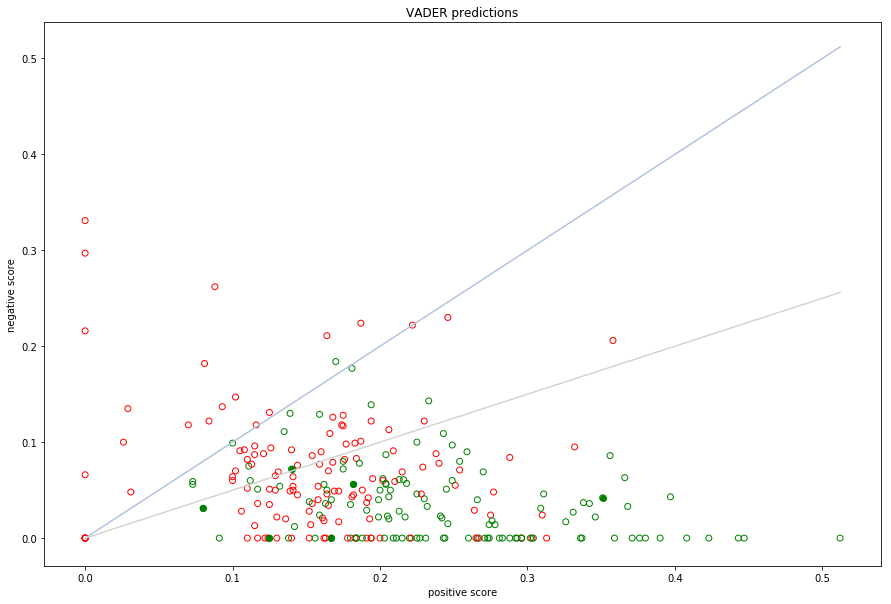

In [15]:
pos, neg = ModelVader(final_df)
final_df['VADER_pos'] = pos
final_df['VADER_neg'] = neg

PlotValues(df = final_df, xvalsCol = 'VADER_pos', yvalsCol = 'VADER_neg', catsCol = 'Vote', 
           title = "VADER predictions", xlab = "positive score", ylab = "negative score", crossParty = True)

#### Lui Hu (Opinion Lexicon)

100% |########################################################################|
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


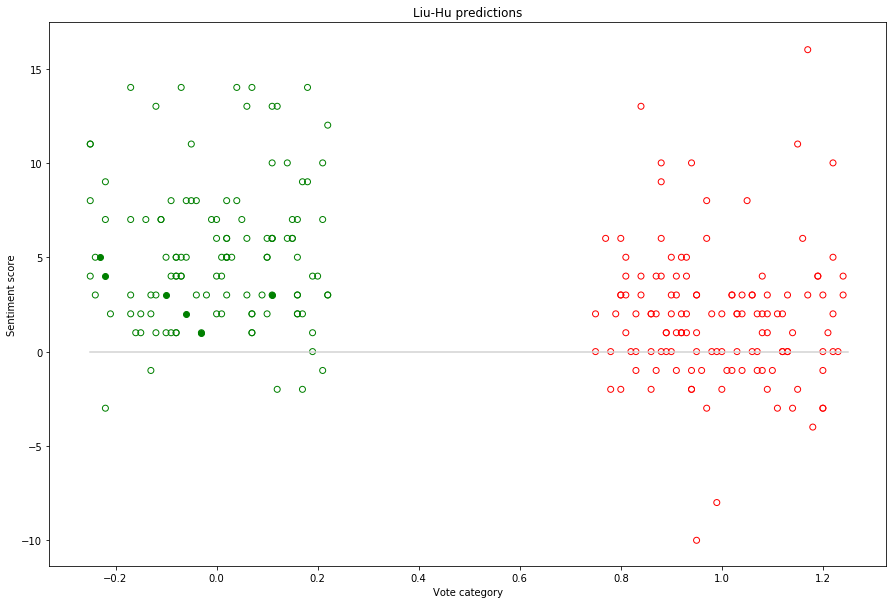

In [16]:
LH_sent, LH_sent_diff = ModelLiuHu(final_df)
final_df['LH_sent'] = LH_sent
final_df['LH_sent_diff'] = LH_sent_diff

PlotLiuHu(final_df, valsCol = 'LH_sent', catsCol = 'Vote', 
          title = "Liu-Hu predictions", xlab = "Vote category", ylab = "Sentiment score", crossParty = True)

#### SentiWordNet

100% |########################################################################|
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of

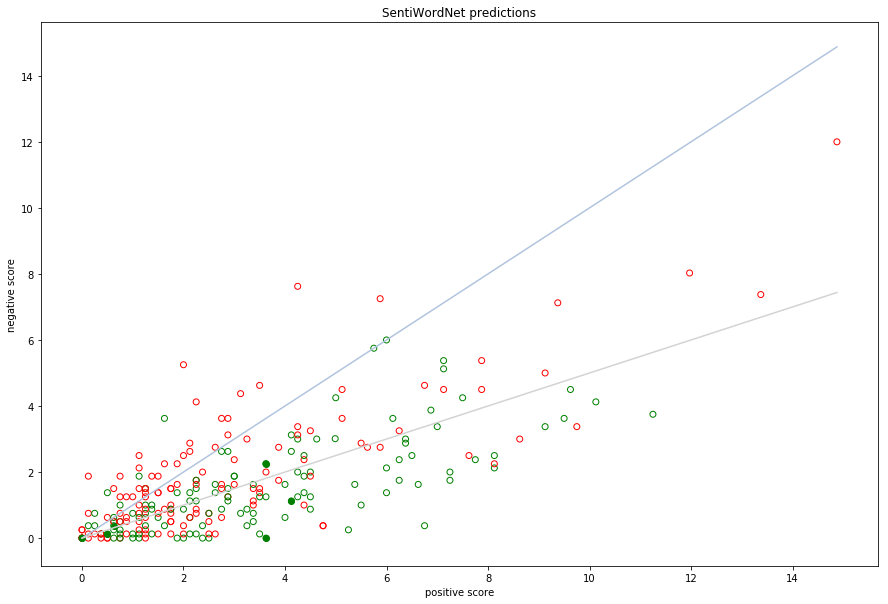

In [17]:
WN_pos, WN_neg, WN_avg = ModelSentiWN(final_df)
final_df['WN_pos'] = WN_pos
final_df['WN_neg'] = WN_neg
final_df['WN_avg'] = WN_avg

PlotValues(df = final_df, xvalsCol = 'WN_pos', yvalsCol = 'WN_neg', catsCol = 'Vote', 
           title = "SentiWordNet predictions", xlab = "positive score", ylab = "negative score", crossParty = True)

## Further Filtering Statements for 'Subjective' Sentences

In [18]:
# filtering for Objective and Subjective statements
n_train = 500
subj_train = [(sent) for sent in subjectivity.sents(categories = 'subj')][:n_train]
obj_train = [(sent) for sent in subjectivity.sents(categories = 'obj')][:n_train]


train_data = []
train_labels = []
for sent in subj_train:
    # un-tokenize for Vectorization as you add to training data list
    s = ' '.join(sent)
    train_data.append(s)
    train_labels.append(1)
for sent in obj_train:
    s = ' '.join(sent)
    train_data.append(s)
    train_labels.append(0)
    
vectorizer = CountVectorizer(analyzer = 'word', stop_words = "english")
fitmat = vectorizer.fit_transform(train_data)
vocab1 = vectorizer.vocabulary_
test_vectorizer = CountVectorizer(analyzer = 'word', vocabulary = vocab1, stop_words = "english")

# Naive Bayes model
NBmodel = BernoulliNB()
NBmodel.fit(fitmat, train_labels)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [19]:
# Filter statements and add only subjective sentences to Data Frame

p=False # print for debugging
pbar = ProgressBar()  # progress bar for loop

subjStatements = [] 

for ind in pbar(range(len(final_df))):
    subj_statement = []
    
    # get the statement text
    if p: print("Analyzing statement " + str(ind) + "\n")
    statement = final_df['FinalStatement'].values[ind]
    
    split_s = statement.split(".")
    test_mat = test_vectorizer.fit_transform(split_s)
    y_pred = NBmodel.predict(test_mat)
    
    # for each sentence in the statement
    for sent_ind in range(len(split_s)):
        if p: print(split_s[sent_ind])
        
        if y_pred[sent_ind] == 1:
            subj_statement.append(split_s[sent_ind])
            if p: print("Subjective statement!")
        else:
            if p: print("Objective statement")
        
    subjStatements.append('. '.join(subj_statement))

final_df['subjStatements'] = subjStatements
final_df.head()

100% |########################################################################|
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,LastName,FirstName,State,Party,Statement,Vote,isRep,crossVote,FinalStatement,VADER_pos,VADER_neg,LH_sent,LH_sent_diff,WN_pos,WN_neg,WN_avg,subjStatements
0,1,Abraham,Ralph,LA,R,"As a rural doctor, I’ve seen the problems our ...",1,True,False,obamacare made changes that have been nothing...,0.088,0.262,-3,-1.000000,1.125,0.500,0.029762,this is why i will vote to repeal obamacare o...
1,2,Adams,Alma,NC,D,Health care is important to our district and t...,0,False,False,she has been a staunch and ardent supporter o...,0.244,0.000,4,1.000000,0.750,0.500,0.016667,
2,3,Aderholt,Robert,AB,R,It is important that everyone has access to go...,1,True,False,"i opposed the president's healthcare bill, t...",0.167,0.000,3,1.000000,0.375,0.125,0.022727,"i opposed the president's healthcare bill, t..."
6,7,Amodei,Mark,NV,R,ObamaCare mandated that all uninsured American...,1,True,False,obamacare mandated that all uninsured american...,0.174,0.118,1,0.058824,7.875,5.375,0.021930,"obamacare failed to accomplish real reform, an..."
7,8,Arrington,Jodey,TX,R,It’s time to repeal and replace Obamacare.\n\n...,1,True,False,it’s time to repeal and replace obamacare. oba...,0.084,0.122,-10,-0.625000,4.250,7.625,-0.036290,it’s time to repeal and replace obamacare. wh...


In [20]:
linear_weights = NBmodel.feature_log_prob_[1,:] - NBmodel.feature_log_prob_[0,:] # subjective minus objective coefficients

n_features = 20
top_obj_feats = np.argsort(linear_weights)[0:n_features]
top_subj_feats = np.argsort(linear_weights)[-n_features:]

print("Most subjective features:")
for idx in top_subj_feats:
    print("  {:s} ({:.02f})".format(test_vectorizer.get_feature_names()[idx], 
                                    linear_weights[idx]))
    
print("")

print("Most objective features:")
for idx in top_obj_feats:
    print("  {:s} ({:.02f})".format(test_vectorizer.get_feature_names()[idx], 
                                    linear_weights[idx]))

Most subjective features:
  charm (1.79)
  half (1.79)
  nearly (1.79)
  genre (1.79)
  films (1.79)
  thing (1.87)
  movies (1.87)
  director (1.90)
  directed (1.95)
  engaging (1.95)
  title (1.95)
  stuff (1.95)
  performances (2.08)
  acting (2.08)
  matter (2.08)
  movie (2.25)
  interesting (2.30)
  hollywood (2.40)
  character (2.40)
  isn (2.64)

Most objective features:
  friends (-2.83)
  lives (-2.71)
  group (-2.30)
  secret (-2.20)
  dead (-2.20)
  father (-2.14)
  night (-2.08)
  friend (-2.08)
  money (-2.08)
  follows (-2.08)
  prison (-2.08)
  called (-2.08)
  save (-2.08)
  order (-2.08)
  jack (-2.08)
  ex (-2.08)
  agent (-2.08)
  begins (-2.08)
  daughter (-2.08)
  mom (-1.95)


In [21]:
n_examples = 5
for ex in range(n_examples):
    print("\n---Original statement was: \n")
    print(final_df['FinalStatement'].values[ex])
    print("\n ---Subjective statement is: \n")
    print(final_df['subjStatements'].values[ex])


---Original statement was: 

 obamacare made changes that have been nothing short of a complete failure: people losing their insurance and being forced onto the exchanges, increased uncertainty, wasted taxpayer dollars, and hiked premiums. this is why i will vote to repeal obamacare on every level at every opportunity

 ---Subjective statement is: 

 this is why i will vote to repeal obamacare on every level at every opportunity

---Original statement was: 

 she has been a staunch and ardent supporter of the affordable care act, which has brought lifesaving insurance coverage to millions, including hundreds of thousands in north carolina’s 12th district

 ---Subjective statement is: 



---Original statement was: 

  i opposed the president's healthcare bill, the patient protection and affordable care act (ppaca), also known as obamacare

 ---Subjective statement is: 

  i opposed the president's healthcare bill, the patient protection and affordable care act (ppaca), also known as o

In [22]:
# remove entries that don't have SUBJECTIVE statement data
subj_df = final_df.drop(['VADER_pos', 'VADER_neg', 'LH_sent', 'LH_sent_diff', 'WN_pos', 'WN_neg', 'WN_avg'], axis = 1)
subj_df = subj_df[subj_df.subjStatements != '']

# Stats of interest
# total data rows
print(str(len(subj_df)) + " total rows")

# number of cross-votes (republicans voting no)
print(str(sum(subj_df.crossVote)) + " cross-votes")

217 total rows
5 cross-votes


In [23]:
subj_df.head()

,ID,LastName,FirstName,State,Party,Statement,Vote,isRep,crossVote,FinalStatement,subjStatements
0,1,Abraham,Ralph,LA,R,"As a rural doctor, I’ve seen the problems our ...",1,True,False,obamacare made changes that have been nothing...,this is why i will vote to repeal obamacare o...
2,3,Aderholt,Robert,AB,R,It is important that everyone has access to go...,1,True,False,"i opposed the president's healthcare bill, t...","i opposed the president's healthcare bill, t..."
6,7,Amodei,Mark,NV,R,ObamaCare mandated that all uninsured American...,1,True,False,obamacare mandated that all uninsured american...,"obamacare failed to accomplish real reform, an..."
7,8,Arrington,Jodey,TX,R,It’s time to repeal and replace Obamacare.\n\n...,1,True,False,it’s time to repeal and replace obamacare. oba...,it’s time to repeal and replace obamacare. wh...
8,9,Babin,Brian,TX,R,I promised the people of the 36th District of ...,1,True,False,i promised the people of the 36th district of ...,i promised the people of the 36th district of ...


## Modeling on SUBJECTIVE Statements

#### VADER

100% |########################################################################|


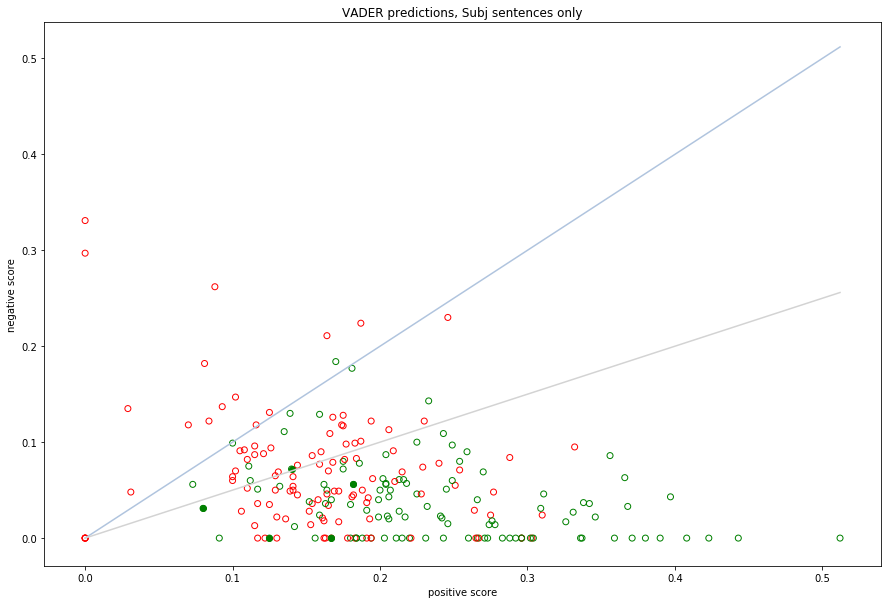

In [24]:
pos, neg = ModelVader(subj_df)
subj_df['VADER_pos'] = pos
subj_df['VADER_neg'] = neg

PlotValues(df = subj_df, xvalsCol = 'VADER_pos', yvalsCol = 'VADER_neg', catsCol = 'Vote', 
           title = "VADER predictions, Subj sentences only", xlab = "positive score", ylab = "negative score", crossParty = True)

#### Liu Hu (Opinion Lexicon)

100% |########################################################################|


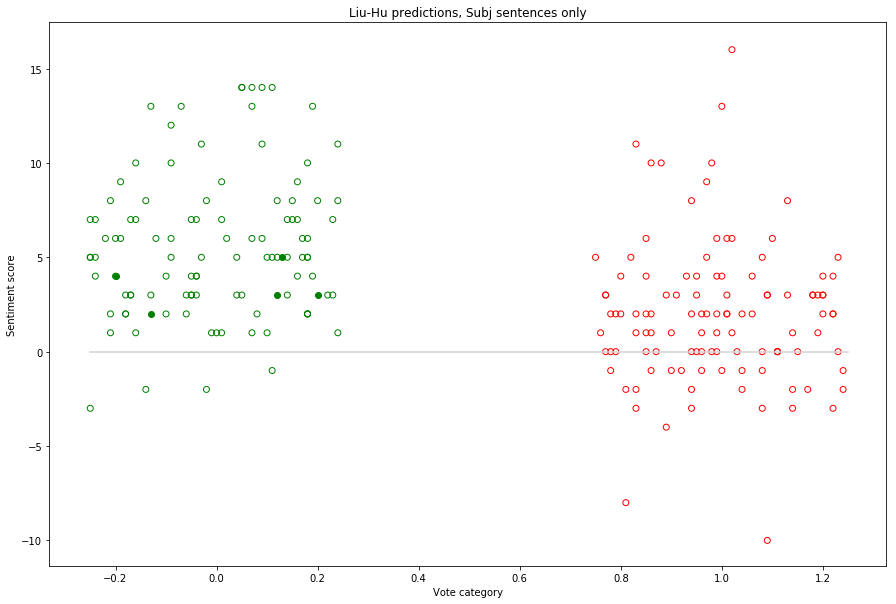

In [25]:
LH_sent, LH_sent_diff = ModelLiuHu(subj_df)
subj_df['LH_sent'] = LH_sent
subj_df['LH_sent_diff'] = LH_sent_diff

PlotLiuHu(subj_df, valsCol = 'LH_sent', catsCol = 'Vote', 
          title = "Liu-Hu predictions, Subj sentences only", xlab = "Vote category", ylab = "Sentiment score", crossParty = True)

#### SentiWordNet

100% |########################################################################|


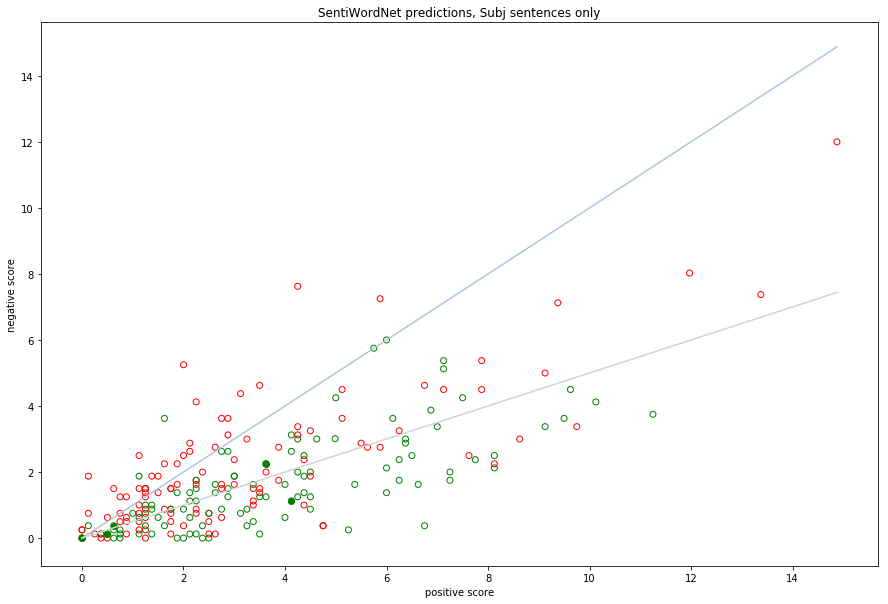

In [26]:
WN_pos, WN_neg, WN_avg = ModelSentiWN(subj_df)
subj_df['WN_pos'] = WN_pos
subj_df['WN_neg'] = WN_neg
subj_df['WN_avg'] = WN_avg

PlotValues(df = subj_df, xvalsCol = 'WN_pos', yvalsCol = 'WN_neg', catsCol = 'Vote', 
           title = "SentiWordNet predictions, Subj sentences only", xlab = "positive score", ylab = "negative score", crossParty = True)

## Accuracy Metrics

In [27]:
def CalculateAccuracies(df):

    # separate out dfs for yes and no accuracies
    yes_df = df[df['Vote'] == 1]
    no_df = df[df['Vote'] == 0]
    cross_df = df[df['crossVote'] == True]
    
    # Given the simple pos<neg model:
    
    # VADER accuracy
    Vacc = sum((df['VADER_pos']<df['VADER_neg']) == df['Vote'])/len(df)
    Vacc_y = sum(yes_df['VADER_pos']<yes_df['VADER_neg'])/len(yes_df)
    Vacc_n = sum(no_df['VADER_pos']>no_df['VADER_neg'])/len(no_df)
    Vacc_c = sum((cross_df['VADER_pos']<cross_df['VADER_neg']) == cross_df['Vote'])/len(cross_df)
    print("The VADER model had an overall accuracy of " + str(round(Vacc*100, 2)) + "%.\n" + 
          "   For YES voters, the accuracy was " + str(round(Vacc_y*100, 2)) + "%. \n" + 
          "   For NO voters, the accuracy was " + str(round(Vacc_n*100, 2)) + "%. \n" + 
          "   For cross-Party voters, the accuracy was " + str(round(Vacc_c*100, 2)) + "%.")
    cm = confusion_matrix(df['Vote'], (df['VADER_pos']<df['VADER_neg']), labels = [0,1])
    print("The confusion matrix is below.")
    print(cm)
    print("\n")
    
    # LiuHu accuracy
    LHacc = sum((df['LH_sent']<0) == df['Vote'])/len(df)
    LHacc_y = sum((yes_df['LH_sent']<0))/len(yes_df)
    LHacc_n = sum((no_df['LH_sent']>0))/len(no_df)
    LHacc_c = sum((cross_df['LH_sent']<0) == cross_df['Vote'])/len(cross_df)
    print("The LiuHu model had an overall accuracy of " + str(round(LHacc*100, 2)) + "%.\n" + 
          "   For YES voters, the accuracy was " + str(round(LHacc_y*100, 2)) + "%. \n" + 
          "   For NO voters, the accuracy was " + str(round(LHacc_n*100, 2)) + "%. \n" + 
          "   For cross-Party voters, the accuracy was " + str(round(LHacc_c*100, 2)) + "%.")  
    cm = confusion_matrix(df['Vote'], (df['LH_sent']<0), labels = [0,1])
    print("The confusion matrix is below.")
    print(cm)
    print("\n")
    
    # SentiWordNet accuracy
    WNacc = sum((df['WN_pos']<df['WN_neg']) == df['Vote'])/len(df)
    WNacc_y = sum(yes_df['WN_pos']<yes_df['WN_neg'])/len(yes_df)
    WNacc_n = sum(no_df['WN_pos']>no_df['WN_neg'])/len(no_df)
    WNacc_c = sum((cross_df['WN_pos']<cross_df['WN_neg']) == cross_df['Vote'])/len(cross_df)
    print("The SentiWordNet model had an overall accuracy of " + str(round(WNacc*100, 2)) + "%.\n" + 
          "   For YES voters, the accuracy was " + str(round(WNacc_y*100, 2)) + "%. \n" + 
          "   For NO voters, the accuracy was " + str(round(WNacc_n*100, 2)) + "%. \n" + 
          "   For cross-Party voters, the accuracy was " + str(round(WNacc_c*100, 2)) + "%.")
    cm = confusion_matrix(df['Vote'], (df['WN_pos']<df['WN_neg']), labels = [0,1])
    print("The confusion matrix is below.")
    print(cm)
    print("\n")
    
    
    
    # GIVEN A 0.5-slope dividing line
    print("GIVEN AN ADJUSTED-SLOPE DIVIDING LINE: \n")
    # VADER accuracy
    Vacc = sum((0.5*df['VADER_pos']<df['VADER_neg']) == df['Vote'])/len(df)
    Vacc_y = sum(0.5*yes_df['VADER_pos']<yes_df['VADER_neg'])/len(yes_df)
    Vacc_n = sum(0.5*no_df['VADER_pos']>no_df['VADER_neg'])/len(no_df)
    Vacc_c = sum((0.5*cross_df['VADER_pos']<cross_df['VADER_neg']) == cross_df['Vote'])/len(cross_df)
    print("The VADER model had an overall accuracy of " + str(round(Vacc*100, 2)) + "%.\n" + 
          "   For YES voters, the accuracy was " + str(round(Vacc_y*100, 2)) + "%. \n" + 
          "   For NO voters, the accuracy was " + str(round(Vacc_n*100, 2)) + "%. \n" + 
          "   For cross-Party voters, the accuracy was " + str(round(Vacc_c*100, 2)) + "%. \n")  
    cm = confusion_matrix(df['Vote'], (0.5*df['VADER_pos']<df['VADER_neg']), labels = [0,1])
    print("The confusion matrix is below.")
    print(cm)
    print("\n")
    
    # SentiWordNet accuracy
    WNacc = sum((0.5*df['WN_pos']<df['WN_neg']) == df['Vote'])/len(df)
    WNacc_y = sum(0.5*yes_df['WN_pos']<yes_df['WN_neg'])/len(yes_df)
    WNacc_n = sum(0.5*no_df['WN_pos']>no_df['WN_neg'])/len(no_df)
    WNacc_c = sum((0.5*cross_df['WN_pos']<cross_df['WN_neg']) == cross_df['Vote'])/len(cross_df)
    print("The SentiWordNet model had an overall accuracy of " + str(round(WNacc*100, 2)) + "%.\n" + 
          "   For YES voters, the accuracy was " + str(round(WNacc_y*100, 2)) + "%. \n" + 
          "   For NO voters, the accuracy was " + str(round(WNacc_n*100, 2)) + "%. \n" + 
          "   For cross-Party voters, the accuracy was " + str(round(WNacc_c*100, 2)) + "%. \n")
    cm = confusion_matrix(df['Vote'], (0.5*df['WN_pos']<df['WN_neg']), labels = [0,1])
    print("The confusion matrix is below.")
    print(cm)
    print("\n")
    
    
    return 

#### Full Statements

In [28]:
CalculateAccuracies(final_df)

The VADER model had an overall accuracy of 54.8%.
   For YES voters, the accuracy was 13.18%. 
   For NO voters, the accuracy was 99.17%. 
   For cross-Party voters, the accuracy was 100.0%.
The confusion matrix is below.
[[120   1]
 [112  17]]


The LiuHu model had an overall accuracy of 57.6%.
   For YES voters, the accuracy was 21.71%. 
   For NO voters, the accuracy was 95.04%. 
   For cross-Party voters, the accuracy was 100.0%.
The confusion matrix is below.
[[116   5]
 [101  28]]


The SentiWordNet model had an overall accuracy of 58.4%.
   For YES voters, the accuracy was 25.58%. 
   For NO voters, the accuracy was 89.26%. 
   For cross-Party voters, the accuracy was 100.0%.
The confusion matrix is below.
[[113   8]
 [ 96  33]]


GIVEN AN ADJUSTED-SLOPE DIVIDING LINE: 

The VADER model had an overall accuracy of 62.4%.
   For YES voters, the accuracy was 37.21%. 
   For NO voters, the accuracy was 89.26%. 
   For cross-Party voters, the accuracy was 83.33%. 

The confusion matr

#### Subjective Statements

In [29]:
CalculateAccuracies(subj_df)

The VADER model had an overall accuracy of 55.3%.
   For YES voters, the accuracy was 12.73%. 
   For NO voters, the accuracy was 99.07%. 
   For cross-Party voters, the accuracy was 100.0%.
The confusion matrix is below.
[[106   1]
 [ 96  14]]


The LiuHu model had an overall accuracy of 58.53%.
   For YES voters, the accuracy was 21.82%. 
   For NO voters, the accuracy was 96.26%. 
   For cross-Party voters, the accuracy was 100.0%.
The confusion matrix is below.
[[103   4]
 [ 86  24]]


The SentiWordNet model had an overall accuracy of 61.29%.
   For YES voters, the accuracy was 27.27%. 
   For NO voters, the accuracy was 92.52%. 
   For cross-Party voters, the accuracy was 100.0%.
The confusion matrix is below.
[[103   4]
 [ 80  30]]


GIVEN AN ADJUSTED-SLOPE DIVIDING LINE: 

The VADER model had an overall accuracy of 63.13%.
   For YES voters, the accuracy was 37.27%. 
   For NO voters, the accuracy was 89.72%. 
   For cross-Party voters, the accuracy was 80.0%. 

The confusion ma

#### Accuracy on Cross-Voters

In [30]:
focus_df = final_df[final_df['crossVote'] == True]
focus_df.head()

,ID,LastName,FirstName,State,Party,Statement,Vote,isRep,crossVote,FinalStatement,VADER_pos,VADER_neg,LH_sent,LH_sent_diff,WN_pos,WN_neg,WN_avg,subjStatements
20,21,Biggs,Andy,AZ,R,"When Barack Obama, Harry Reid, and Nancy Pelos...",0,True,True,"when barack obama, harry reid, and nancy pelos...",0.080,0.031,2,0.200000,3.625,2.250,0.018836,"when barack obama, harry reid, and nancy pelos..."
112,113,Donovan,Daniel,NY,R,America continues to lead the world in healthc...,0,True,True,the affordable care act failed to address ma...,0.140,0.072,4,0.666667,0.500,0.125,0.015000,the affordable care act failed to address ma...
196,197,Jones,Walter,NC,R,Health care is a very personal issue between h...,0,True,True,that is why i strongly opposed and voted aga...,0.125,0.000,3,1.000000,0.625,0.375,0.010870,that is why i strongly opposed and voted aga...
316,317,Reichert,David,WA,R,I continue to believe that we can advance prop...,0,True,True,i remain committed to protecting and strength...,0.351,0.042,1,0.200000,3.625,0.000,0.157609,
331,332,Ros-Lehtinen,Ileana,FL,R,Increasing the affordability of healthcare thr...,0,True,True,i know that many people in our community are w...,0.182,0.056,5,0.555556,4.125,1.125,0.073171,if we want to preserve the good aspects of ppa...


In [32]:
# Print the cross-voting statements
for row in range(len(focus_df)):
    print("")
    print(focus_df['LastName'].values[row])
    print("")
    print(focus_df['FinalStatement'].values[row])
    print("----------------------")


Biggs

when barack obama, harry reid, and nancy pelosi rammed obamacare down the throats of americans, they did so knowing that their legislation was an intentional takeover of one-sixth of the economy, but provided an unknown commodity. no truer words have been spoken than nancy pelosi’s “we must pass obamacare to find out what’s in it.”once obamacare passed, the country quickly learned what she meant. obamacare has become a pariah for all who helped with its passage, and has led to unaffordable premiums and fewer options.for years, republicans have promised to repeal obamacare.since taking office at the start of the 115th congress, i have advocated for the immediate passage of a bill that completely repeals obamacare and all the regulations associated with it.after we repeal obamacare i support passing further legislation to remove the federal government from the unconstitutional role of regulating our nation's healthcare system.i am committed to the challenge of eliminating obamaca

## Naive Bayes Fit Model, with Minimal Training

In [33]:
feats_list = ['VADER_pos', 'VADER_neg', 'LH_sent', 'WN_pos', 'WN_neg']
feats = final_df.loc[:, feats_list].as_matrix()

labels = final_df.loc[:, 'Vote'].as_matrix()

print(feats.shape)
print(labels.shape)

(250, 5)
(250,)


/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


#### 5-fold cross-Validation

In [34]:
kf = KFold(n_splits = 5, shuffle=True)
kf.get_n_splits(feats)

print(kf)
#for train_index, test_index in kf.split(test_data):
#    print("TRAIN:" + str(train_index) + "TEST:" + str(test_index))

KFold(n_splits=5, random_state=None, shuffle=True)


In [35]:
Acc_list = []

for train_index, test_index in kf.split(feats):
    train_data = feats[train_index]
    train_labels = labels[train_index]
    test_data = feats[test_index]
    test_labels = labels[test_index]
    
    NBmodel = BernoulliNB()
    NBmodel.fit(train_data, train_labels)    
    y_pred = NBmodel.predict(test_data)

    # Accuracy
    acc = accuracy_score(test_labels, y_pred)
    Acc_list.append(acc)
    
print("The accuracy of this trained model is " + str(round(np.average(Acc_list)*100, 2)) + "%. ")

The accuracy of this trained model is 65.6%. 


#### Same Model on Subjective Statements

In [36]:
feats_list = ['VADER_pos', 'VADER_neg', 'LH_sent', 'WN_pos', 'WN_neg']
feats = subj_df.loc[:, feats_list].as_matrix()

labels = subj_df.loc[:, 'Vote'].as_matrix()

print(feats.shape)
print(labels.shape)

kf = KFold(n_splits = 5, shuffle=True)
kf.get_n_splits(test_data)

Acc_list = []

for train_index, test_index in kf.split(feats):
    train_data = feats[train_index]
    train_labels = labels[train_index]
    test_data = feats[test_index]
    test_labels = labels[test_index]
    
    NBmodel = BernoulliNB()
    NBmodel.fit(train_data, train_labels)    
    y_pred = NBmodel.predict(test_data)

    # Accuracy
    acc = accuracy_score(test_labels, y_pred)
    Acc_list.append(acc)
    
print("The accuracy of this trained model is " + str(round(np.average(Acc_list)*100, 2)) + "%. ")

(217, 5)
(217,)
The accuracy of this trained model is 67.27%. 


/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/krissy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
